In [7]:
# import packages

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
# import data

df = pd.read_pickle("../data/usa_classified_tweets.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152945 entries, 0 to 152944
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   152945 non-null  int64  
 1   text                 152945 non-null  object 
 2   location             152945 non-null  object 
 3   total_pop            152945 non-null  float64
 4   women                152945 non-null  float64
 5   hispanic             152945 non-null  float64
 6   white                152945 non-null  float64
 7   black                152945 non-null  float64
 8   other_ethnicities    152945 non-null  float64
 9   income_per_cap       152945 non-null  float64
 10  unemployment         152945 non-null  float64
 11  poverty              152945 non-null  float64
 12  democrats            152945 non-null  float64
 13  republicans          152945 non-null  float64
 14  voting_age_citizens  152945 non-null  float64
 15  believer_denier  

In [4]:
df = df.drop(columns=['id', 'text', 'location', 'total_pop'])

In [16]:
X = df.drop('believer_denier', axis=1)

y = df['believer_denier']

## Baseline Model

In [17]:
from sklearn.dummy import DummyClassifier

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)
y_pred = dummy.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10421
           1       0.66      1.00      0.79     20168

    accuracy                           0.66     30589
   macro avg       0.33      0.50      0.40     30589
weighted avg       0.43      0.66      0.52     30589



In [64]:
# Save this model

pickle.dump(dummy, open('baseline_task2.pkl','wb'))

## RF with Oversampling

In [26]:
y.value_counts()

1    100749
0     52196
Name: believer_denier, dtype: int64

In [42]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(X, y)
# new class distribution 
print(Counter(y_ros))

Counter({0: 100749, 1: 100749})


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

In [44]:
# run model and generate classification report
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61     20278
           1       0.61      0.64      0.62     20022

    accuracy                           0.62     40300
   macro avg       0.62      0.62      0.62     40300
weighted avg       0.62      0.62      0.62     40300



In [45]:
train_probs = model.predict_proba(X_train)[:,1] 
probs = model.predict_proba(X_test)[:, 1]
train_predictions = model.predict(X_train)

In [46]:
# print ROC AUC scores
print(f'Train ROC AUC Score: {round(roc_auc_score(y_train, train_probs),2)}')
print(f'Test ROC AUC  Score: {round(roc_auc_score(y_test, probs),2)}')

Train ROC AUC Score: 0.68
Test ROC AUC  Score: 0.67


Baseline: {1.0} Test: {0.64} Train: {0.64}
Baseline: {0.5} Test: {0.61} Train: {0.62}
Baseline: {0.5} Test: {0.67} Train: {0.68}


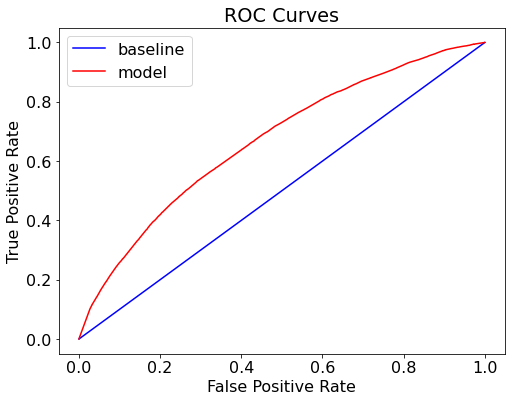

In [47]:
#https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print('Baseline:', {round(baseline[metric], 2)}, 
                 'Test:', {round(results[metric], 2)}, 
                 'Train:', {round(train_results[metric], 2)})
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
evaluate_model(y_pred,probs,train_predictions,train_probs)

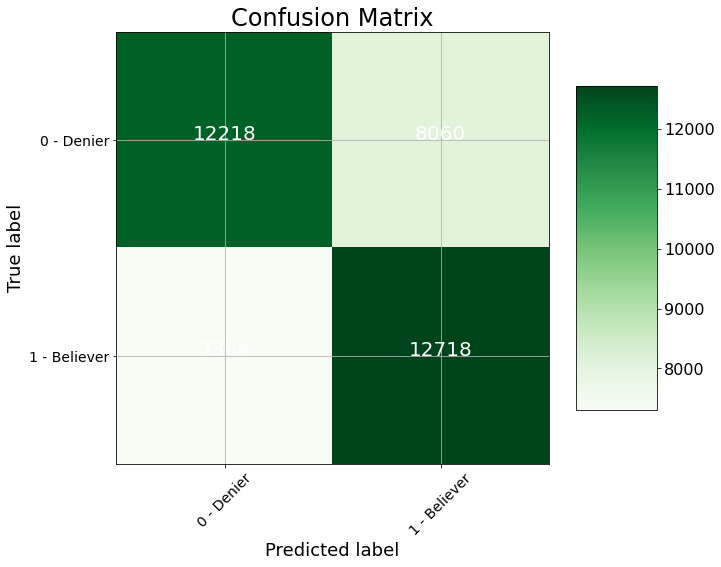

In [48]:
#https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Denier', '1 - Believer'],
                      title = 'Confusion Matrix')

## Parameter Tuning

In [49]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

In [50]:
#https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

In [ ]:
# Create base model to tune
rf = RandomForestClassifier(oob_score=True)
# Create random search model and fit the data
rf_random = RandomizedSearchCV(
                        estimator = rf,
                        param_distributions = random_grid,
                        n_iter = 100, cv = 3,
                        verbose=2, random_state=43, 
                        scoring='roc_auc')
rf_random.fit(X_train, y_train)
rf_random.best_params_
rf_random.best_params_

## Prediction and Feature Importance

{'n_estimators': 687,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 49,
 'max_features': 'log2',
 'max_depth': 60,
 'bootstrap': True}

In [51]:
best_model = RandomForestClassifier(n_estimators=687,
                                       min_samples_split=2,
                                       min_samples_leaf=4,
                                       max_leaf_nodes=49,
                                       max_features='log2',
                                       max_depth=60,
                                       bootstrap=True)

In [53]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62     20278
           1       0.61      0.61      0.61     20022

    accuracy                           0.62     40300
   macro avg       0.62      0.62      0.62     40300
weighted avg       0.62      0.62      0.62     40300



Feature: 0, Score: 0.03401
Feature: 1, Score: 0.03192
Feature: 2, Score: 0.03867
Feature: 3, Score: 0.06589
Feature: 4, Score: 0.07877
Feature: 5, Score: 0.12666
Feature: 6, Score: 0.03235
Feature: 7, Score: 0.02352
Feature: 8, Score: 0.23665
Feature: 9, Score: 0.29311
Feature: 10, Score: 0.03844


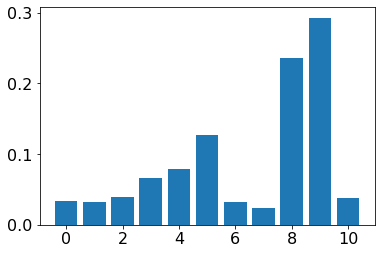

In [55]:
# Find scores that show how important each feature is

importance = best_model.feature_importances_

importances_dict = {}

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    importances_dict[i] = v

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [56]:
import pprint

importance_dic = {}

for feat, importance in zip(X.columns, best_model.feature_importances_):
    #print('feature:', {feat}, 'importance:', {importance})
    importance_dic[feat] = importance
    
pprint.pprint(sorted(importance_dic.items(), key = lambda x: x[1], reverse = True))

[('republicans', 0.293114664792611),
 ('democrats', 0.23664925210633758),
 ('income_per_cap', 0.12666427801977184),
 ('other_ethnicities', 0.0787658621542777),
 ('black', 0.06589091444056808),
 ('white', 0.03867056085677531),
 ('voting_age_citizens', 0.038438654717806386),
 ('women', 0.03400594660628936),
 ('unemployment', 0.03235490258063368),
 ('hispanic', 0.03192256135201199),
 ('poverty', 0.023522402372917185)]
